In [41]:
import time

import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp_spec
import scipy.stats as sp_stats

## Assignment 2A. Problem 2.2.8 SVI.

### Generate data
The cell below generates data for the LDA model. Note, for simplicity, we are using N_d = N for all d.

In [42]:
import torch
import torch.distributions as t_dist

def generate_data(D, N, K, W, eta, alpha):
    """
    Torch implementation for generating data using the LDA model. Faster for larger datasets.
    D = number of documents
    N = number of words in each document
    K = number of topics
    W = number of words in vocabulary
    """
    # sample K topics
    beta_dist = t_dist.Dirichlet(torch.from_numpy(eta))
    beta = beta_dist.sample([K])  # size K x W

    # sample document topic distribution
    theta_dist = t_dist.Dirichlet(torch.from_numpy(alpha))
    theta = theta_dist.sample([D]) # size D x K

    # sample word to topic assignment
    z_dist = t_dist.OneHotCategorical(probs=theta)
    z = z_dist.sample([N])
    z = torch.einsum("ndk->dnk", z)

    # sample word from selected topics
    beta_select = torch.einsum("kw, dnk -> dnw", beta, z)
    w_dist = t_dist.OneHotCategorical(probs=beta_select)
    w = w_dist.sample([1])

    w = w.reshape(D, N, W)

    return w.numpy(), z.numpy(), theta.numpy(), beta.numpy()

torch.manual_seed(1)

D_sim = 500
N_sim = 1000
K_sim = 2
W_sim = 10

eta_sim = np.ones(W_sim)
eta_sim[3] = 0.0001     # Expect word 3 to not appear in data
eta_sim[1] = 3.         # Expect word 1 to be most common in data
alpha_sim = np.ones(K_sim) * 1.0
w0, z0, theta0, beta0 = generate_data(D_sim, N_sim, K_sim, W_sim, eta_sim, alpha_sim)
w_cat = w0.argmax(axis=-1)  # remove one hot encoding
unique_z, counts_z = numpy.unique(z0[0, :], return_counts=True)
unique_w, counts_w = numpy.unique(w_cat[0, :], return_counts=True)

# Sanity checks for data generation
print(f"Average z of each document should be close to theta of document. \n Theta of doc 0: {theta0[0]}"
      f" \n Mean z of doc 0: {z0[0].mean(axis=0)}")
print(f"Beta of topic 0: {beta0[0]}")
print(f"Beta of topic 1: {beta0[1]}")
print(f"Word to topic assignment, z, of document 0: {z0[0, 0:10]}")
print(f"Observed words, w, of document 0: {w_cat[0, 0:10]}")
print(f"Unique words and count of document 0: {[f'{u}: {c}' for u, c in zip(unique_w, counts_w)]}")

Average z of each document should be close to theta of document. 
 Theta of doc 0: [0.140 0.860] 
 Mean z of doc 0: [0.144 0.856]
Beta of topic 0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
Beta of topic 1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]
Word to topic assignment, z, of document 0: [[1.000 0.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]]
Observed words, w, of document 0: [0 8 0 0 6 7 1 9 0 6]
Unique words and count of document 0: ['0: 348', '1: 235', '2: 59', '4: 10', '5: 89', '6: 96', '7: 52', '8: 28', '9: 83']


### Helper functions

In [43]:
def log_multivariate_beta_function(a, axis=None):
    return np.sum(sp_spec.gammaln(a)) - sp_spec.gammaln(np.sum(a, axis=axis))

### CAVI Implementation, ELBO and initialization

In [44]:
def initialize_q(w, D, N, K, W):
    """
    Random initialization.
    """
    phi_init = np.random.random(size=(D, N, K))
    phi_init = phi_init / np.sum(phi_init, axis=-1, keepdims=True)
    gamma_init = np.random.randint(1, 10, size=(D, K))
    lmbda_init = np.random.randint(1, 10, size=(K, W))
    return phi_init, gamma_init, lmbda_init

def update_q_Z(w, gamma, lmbda):
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((D, N, K))
    w_label = w.argmax(axis=-1)
    for d in range(D):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[d, n, :] = log_rho_n

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    return phi

def update_q_theta(phi, alpha):
    E_Z = phi
    D, N, K = phi.shape
    gamma = np.zeros((D, K))
    for d in range(D):
        E_Z_d = E_Z[d]
        gamma[d] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta(w, phi, eta):
    E_Z = phi
    D, N, W = w.shape
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    for k in range(K):
        lmbda[k, :] = eta
        for d in range(D):
            for n in range(N):
                lmbda[k, :] += E_Z[d,n,k] * w[d,n]  # Sum over d and n
    return lmbda

def calculate_elbo(w, phi, gamma, lmbda, eta, alpha):
    D, N, K = phi.shape
    W = eta.shape[0]
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))  # size K x W
    E_Z = phi  # size D, N, K
    log_Beta_alpha = log_multivariate_beta_function(alpha)
    log_Beta_eta = log_multivariate_beta_function(eta)
    log_Beta_gamma = np.array([log_multivariate_beta_function(gamma[d, :]) for d in range(D)])
    dg_gamma = sp_spec.digamma(gamma)
    log_Beta_lmbda = np.array([log_multivariate_beta_function(lmbda[k, :]) for k in range(K)])
    dg_lmbda = sp_spec.digamma(lmbda)

    neg_CE_likelihood = np.einsum("dnk, kw, dnw", E_Z, E_log_beta, w)
    neg_CE_Z = np.einsum("dnk, dk -> ", E_Z, E_log_theta)
    neg_CE_theta = -D * log_Beta_alpha + np.einsum("k, dk ->", alpha - 1, E_log_theta)
    neg_CE_beta = -K * log_Beta_eta + np.einsum("w, kw ->", eta - 1, E_log_beta)
    H_Z = -np.einsum("dnk, dnk ->", E_Z, np.log(E_Z))
    gamma_0 = np.sum(gamma, axis=1)
    dg_gamma0 = sp_spec.digamma(gamma_0)
    H_theta = np.sum(log_Beta_gamma + (gamma_0 - K) * dg_gamma0 - np.einsum("dk, dk -> d", gamma - 1, dg_gamma))
    lmbda_0 = np.sum(lmbda, axis=1)
    dg_lmbda0 = sp_spec.digamma(lmbda_0)
    H_beta = np.sum(log_Beta_lmbda + (lmbda_0 - W) * dg_lmbda0 - np.einsum("kw, kw -> k", lmbda - 1, dg_lmbda))
    return neg_CE_likelihood + neg_CE_Z + neg_CE_theta + neg_CE_beta + H_Z + H_theta + H_beta

def CAVI_algorithm(w, K, n_iter, eta, alpha):
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))

  for i in range(0, n_iter):

    ###### CAVI updates #######

    # q(Z) update
    phi = update_q_Z(w, gamma, lmbda)

    # q(theta) update
    gamma = update_q_theta(phi, alpha)

    # q(beta) update
    lmbda = update_q_beta(w, phi, eta)

    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    phi_out[i] = phi
    gamma_out[i] = gamma
    lmbda_out[i] = lmbda

  return phi_out, gamma_out, lmbda_out, elbo

n_iter0 = 100
K0 = K_sim
W0 = W_sim
eta_prior0 = np.ones(W0)
alpha_prior0 = np.ones(K0)
phi_out0, gamma_out0, lmbda_out0, elbo0 = CAVI_algorithm(w0, K0, n_iter0, eta_prior0, alpha_prior0)
final_phi0 = phi_out0[-1]
final_gamma0 = gamma_out0[-1]
final_lmbda0 = lmbda_out0[-1]

In [45]:
precision = 3
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"Final E[theta] of doc 0 CAVI:  {np.round(final_gamma0[0] / np.sum(final_gamma0[0], axis=0, keepdims=True), precision)}")
print(f"True theta of doc 0:          {np.round(theta0[0], precision)}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"Final E[beta] k=0: {np.round(final_lmbda0[0, :] / np.sum(final_lmbda0[0, :], axis=-1, keepdims=True), precision)}")
print(f"Final E[beta] k=1: {np.round(final_lmbda0[1, :] / np.sum(final_lmbda0[1, :], axis=-1, keepdims=True), precision)}")
print(f"True beta k=0: {np.round(beta0[0, :], precision)}")
print(f"True beta k=1: {np.round(beta0[1, :], precision)}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
Final E[theta] of doc 0 CAVI:  [0.199 0.801]
True theta of doc 0:          [0.140 0.860]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
Final E[beta] k=0: [0.109 0.320 0.031 0.000 0.008 0.065 0.036 0.097 0.113 0.220]
Final E[beta] k=1: [0.379 0.206 0.086 0.000 0.014 0.102 0.113 0.040 0.005 0.055]
True beta k=0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
True beta k=1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]


### SVI Implementation

Using the CAVI updates as a template, finish the code below.

In [46]:
def update_q_Z_svi(batch, w, gamma, lmbda):
    """
    TODO: rewrite to SVI update
    """
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((len(batch), N, K))
    w_label = w.argmax(axis=-1)
    for idx, d in enumerate(batch):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[idx, n, :] = log_rho_n

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    return phi

def update_q_theta_svi(batch, phi, alpha):
    """
    TODO: rewrite to SVI update
    """
    E_Z = phi
    D, N, K = phi.shape
    gamma = np.zeros((len(batch), K))
    for idx, d in enumerate(batch):
        E_Z_d = E_Z[d]
        gamma[idx] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta_svi(batch, w, phi, eta):
    """
    TODO: rewrite to SVI update
    """
    E_Z = phi
    D, N, W = w.shape
    # w_batch = w[batch]
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    for k in range(K):
        lmbda[k, :] = eta
        for idx, d in enumerate(batch):
            for n in range(N):
                lmbda[k, :] += E_Z[d,n,k] * w[d,n]  # Sum over d and n
    return lmbda

def SVI_algorithm(w, K, S, n_iter, eta, alpha):
  """
  Add SVI Specific code here.
  """
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
#   phi_out = np.zeros((n_iter, D, N, K))
#   gamma_out = np.zeros((n_iter, D, K))
#   lmbda_out = np.zeros((n_iter, K, W))
  phi_out = [phi]
  gamma_out = [gamma]
  lmbda_out = [lmbda]
  
  # Step size schedule
  delay = 10 # int(n_iter/10)
  forgetting_rate = 0.5
  rho = lambda t: (t + delay) ** (-forgetting_rate)
  
  for i in range(0, n_iter):
    # Sample batch and set step size, rho.
    batch = np.random.randint(0, N, size=S)
    rho_t = rho(i)

    ###### SVI updates #######

    # Local updates
    phi_batch = update_q_Z_svi(batch, w, gamma, lmbda)
    phi[batch] = (1 - rho_t) * phi[batch] + rho_t/S * np.sum(phi_batch, axis=0)

    gamma_batch = update_q_theta_svi(batch, phi, alpha)
    gamma[batch] = (1 - rho_t) * gamma[batch] + rho_t/S * np.sum(gamma_batch, axis=0)

    # Global updates
    lmbda_batch = update_q_beta_svi(batch, w, phi, eta)
    lmbda = (1 - rho_t) * lmbda + rho_t/S * np.sum(lmbda_batch, axis=0)

    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    # phi_out[i] = phi
    # gamma_out[i] = gamma
    # lmbda_out[i] = lmbda
    phi_out.append(lmbda)
    gamma_out.append(gamma)
    lmbda_out.append(lmbda)

  return phi_out, gamma_out, lmbda_out, elbo

### CASE 1
Tiny dataset

In [47]:
np.random.seed(0)

# Data simulation parameters
D1 = 50
N1 = 50
K1 = 2
W1 = 5
eta_sim1 = np.ones(W1)
alpha_sim1 = np.ones(K1)

w1, z1, theta1, beta1 = generate_data(D1, N1, K1, W1, eta_sim1, alpha_sim1)

# Inference parameters
n_iter_cavi1 = 100
n_iter_svi1 = 100
eta_prior1 = np.ones(W1) * 1.
alpha_prior1 = np.ones(K1) * 1.
S1 = 5 # batch size

start_cavi1 = time.time()
phi_out1_cavi, gamma_out1_cavi, lmbda_out1_cavi, elbo1_cavi = CAVI_algorithm(w1, K1, n_iter_cavi1, eta_prior1, alpha_prior1)
end_cavi1 = time.time()

start_svi1 = time.time()
phi_out1_svi, gamma_out1_svi, lmbda_out1_svi, elbo1_svi = SVI_algorithm(w1, K1, S1, n_iter_svi1, eta_prior1, alpha_prior1)
end_svi1 = time.time()

final_phi1_cavi = phi_out1_cavi[-1]
final_gamma1_cavi = gamma_out1_cavi[-1]
final_lmbda1_cavi = lmbda_out1_cavi[-1]
final_phi1_svi = phi_out1_svi[-1]
final_gamma1_svi = gamma_out1_svi[-1]
final_lmbda1_svi = lmbda_out1_svi[-1]

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [48]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:  {final_gamma1_svi[0] / np.sum(final_gamma1_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI: {final_gamma1_cavi[0] / np.sum(final_gamma1_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:    {theta1[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] SVI k=0:    {final_lmbda1_svi[0, :] / np.sum(final_lmbda1_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] SVI k=1:    {final_lmbda1_svi[1, :] / np.sum(final_lmbda1_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=0:   {final_lmbda1_cavi[0, :] / np.sum(final_lmbda1_cavi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=1:   {final_lmbda1_cavi[1, :] / np.sum(final_lmbda1_cavi[1, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:      {beta1[0, :]}")
print(f"True beta k=1:      {beta1[1, :]}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:  [0.526 0.474]
E[theta] of doc 0 CAVI: [0.874 0.126]
True theta of doc 0:    [0.025 0.975]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] SVI k=0:    [0.261 0.212 0.272 0.095 0.161]
E[beta] SVI k=1:    [0.261 0.212 0.272 0.095 0.161]
E[beta] CAVI k=0:   [0.375 0.441 0.021 0.083 0.081]
E[beta] CAVI k=1:   [0.167 0.005 0.495 0.100 0.233]
True beta k=0:      [0.195 0.051 0.466 0.077 0.211]
True beta k=1:      [0.332 0.361 0.104 0.087 0.117]


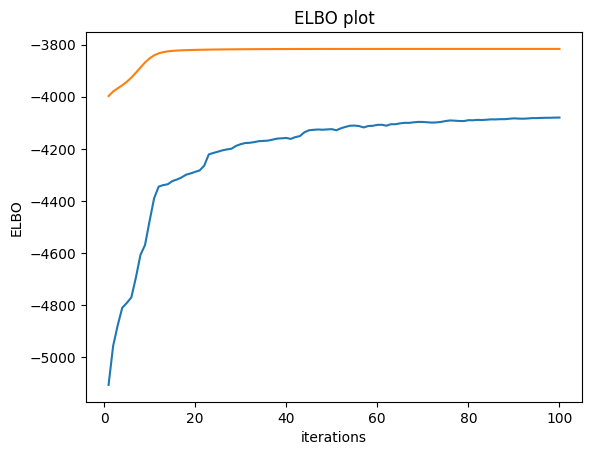

In [49]:
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_svi[np.arange(0, n_iter_svi1, int(n_iter_svi1 / n_iter_cavi1))])
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

In [50]:
# Add your own code for evaluation here (will not be graded)

### CASE 2
Small dataset

In [51]:
np.random.seed(0)

# Data simulation parameters
D2 = 1000
N2 = 50
K2 = 3
W2 = 10
eta_sim2 = np.ones(W2)
alpha_sim2 = np.ones(K2)

w2, z2, theta2, beta2 = generate_data(D2, N2, K2, W2, eta_sim2, alpha_sim2)

# Inference parameters
n_iter_cavi2 = 100
n_iter_svi2 = 100
eta_prior2 = np.ones(W2) * 1.
alpha_prior2 = np.ones(K2) * 1.
S2 = 100 # batch size

start_cavi2 = time.time()
phi_out2_cavi, gamma_out2_cavi, lmbda_out2_cavi, elbo2_cavi = CAVI_algorithm(w2, K2, n_iter_cavi2, eta_prior2, alpha_prior2)
end_cavi2 = time.time()

start_svi2 = time.time()
phi_out2_svi, gamma_out2_svi, lmbda_out2_svi, elbo2_svi = SVI_algorithm(w2, K2, S2, n_iter_svi2, eta_prior2, alpha_prior2)
end_svi2 = time.time()

final_phi2_cavi = phi_out2_cavi[-1]
final_gamma2_cavi = gamma_out2_cavi[-1]
final_lmbda2_cavi = lmbda_out2_cavi[-1]
final_phi2_svi = phi_out2_svi[-1]
final_gamma2_svi = gamma_out2_svi[-1]
final_lmbda2_svi = lmbda_out2_svi[-1]

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [52]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:      {final_gamma2_svi[0] / np.sum(final_gamma2_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI:     {final_gamma2_cavi[0] / np.sum(final_gamma2_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:        {theta2[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] k=0:    {final_lmbda2_svi[0, :] / np.sum(final_lmbda2_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=1:    {final_lmbda2_svi[1, :] / np.sum(final_lmbda2_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=2:    {final_lmbda2_svi[2, :] / np.sum(final_lmbda2_svi[2, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:  {beta2[0, :]}")
print(f"True beta k=1:  {beta2[1, :]}")
print(f"True beta k=2:  {beta2[2, :]}")

print(f"Time SVI: {end_svi2 - start_svi2}")
print(f"Time CAVI: {end_cavi2 - start_cavi2}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:      [0.349 0.326 0.326]
E[theta] of doc 0 CAVI:     [0.259 0.345 0.395]
True theta of doc 0:        [0.650 0.262 0.087]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] k=0:    [0.030 0.030 0.067 0.123 0.198 0.161 0.036 0.163 0.114 0.077]
E[beta] k=1:    [0.030 0.030 0.067 0.123 0.198 0.161 0.036 0.163 0.114 0.077]
E[beta] k=2:    [0.030 0.030 0.067 0.123 0.198 0.161 0.036 0.163 0.114 0.077]
True beta k=0:  [0.053 0.054 0.099 0.104 0.205 0.074 0.087 0.201 0.023 0.101]
True beta k=1:  [0.005 0.001 0.045 0.185 0.146 0.243 0.005 0.082 0.214 0.074]
True beta k=2:  [0.048 0.040 0.065 0.049 0.257 0.147 0.021 0.213 0.090 0.070]
Time SVI: 4.36211085319519
Time CAVI: 30.23467993736267


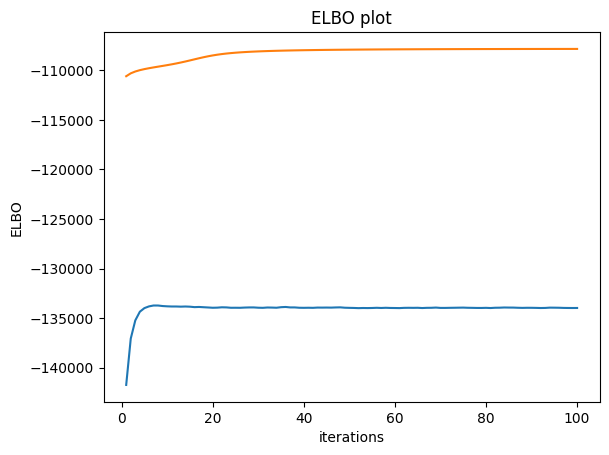

In [53]:
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_svi[np.arange(0, n_iter_svi2, int(n_iter_svi2 / n_iter_cavi2))])
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

In [54]:
# Add your own code for evaluation here (will not be graded)

### CASE 3
Medium small dataset, one iteration for time analysis.

In [55]:
np.random.seed(0)

# Data simulation parameters
D3 = 10**4
N3 = 500
K3 = 5
W3 = 10
eta_sim3 = np.ones(W3)
alpha_sim3 = np.ones(K3)

w3, z3, theta3, beta3 = generate_data(D3, N3, K3, W3, eta_sim3, alpha_sim3)

# Inference parameters
n_iter3 = 1
eta_prior3 = np.ones(W3) * 1.
alpha_prior3 = np.ones(K3) * 1.
S3 = 100 # batch size

start_cavi3 = time.time()
phi_out3_cavi, gamma_out3_cavi, lmbda_out3_cavi, elbo3_cavi = CAVI_algorithm(w3, K3, n_iter3, eta_prior3, alpha_prior3)
end_cavi3 = time.time()

start_svi3 = time.time()
phi_out3_svi, gamma_out3_svi, lmbda_out3_svi, elbo3_svi = SVI_algorithm(w3, K3, S3, n_iter3, eta_prior3, alpha_prior3)
end_svi3 = time.time()

final_phi3_cavi = phi_out3_cavi[-1]
final_gamma3_cavi = gamma_out3_cavi[-1]
final_lmbda3_cavi = lmbda_out3_cavi[-1]
final_phi3_svi = phi_out3_svi[-1]
final_gamma3_svi = gamma_out3_svi[-1]
final_lmbda3_svi = lmbda_out3_svi[-1]

In [56]:
print(f"Examine per iteration run time.")
print(f"Time SVI: {end_svi3 - start_svi3}")
print(f"Time CAVI: {end_cavi3 - start_cavi3}")

Examine per iteration run time.
Time SVI: 2.022953987121582
Time CAVI: 45.49727416038513


In [57]:
# Add your own code for evaluation here (will not be graded)